# Data Exploration and Analysis

In [1]:
# load python basics
import pandas as pd
import numpy as np
from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import datetime as dt
import holidays
import warnings
import time
import pickle
import os


# load SARIMA packages
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import arima, auto_arima                       # for determining ARIMA orders

# load package for metrics
from statsmodels.tools.eval_measures import rmse

# load LSTM packages
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

2024-04-08 03:06:29.583347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 03:06:29.583375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 03:06:29.584557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 03:06:29.590738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 03:06:30.521611: W tensorflow/compiler/tf2

In [2]:
# settings
os.chdir('/home/clementejasonfortuna/workspace/705.603Portfolio/TimeSeries-main/Assignment/analysis')

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

pd.set_option('display.max_columns', None)  # None or 1000
pd.set_option('display.max_rows', 100)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

## Data Analysis, Feature Selection, Aggregation, and Preparation for Modeling

### Ingest and Process the Data

**sort in chronological order:**

In [3]:
df = pd.read_csv('../data/CreditCardFraudFourYears.csv')
df = df.sort_values(by = 'unix_time')
df = df.reset_index()
df

,index,Unnamed: 0,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,1994196,9682,552-71-1370,344458220673235,Michael,Davis,M,716 Joan Islands,Albany,OR,97322,44.6260,-123.0570,58967,Psychiatrist,2000-10-18,748031409868,young_adults_male_urban.json,f95c1619cf1d85ac52a33b4569b3bd05,2018-01-01,00:00:18,1514782818,gas_transport,87.26,0,"fraud_Robel, Cummerata and Prosacco",44.813692,-123.227425
1,222406,94320,055-53-3407,4998795098228,Austin,Adams,M,64818 Jose Street,Newburgh,IN,47630,37.9637,-87.3938,34423,Further education lecturer,1961-02-20,944730249396,adults_50up_male_urban.json,4774dfafbbc96bc9eec1fbca8b955109,2018-01-01,00:00:31,1514782831,gas_transport,77.64,0,"fraud_Tillman, Dickinson and Labadie",37.287170,-87.040229
2,633920,57642,193-38-4575,6517762969143369,Breanna,Jacobs,F,6450 Hannah Creek Apt. 898,Hartford City,IN,47348,40.4541,-85.3758,9828,"Librarian, public",1973-08-09,251168358458,adults_50up_female_urban.json,6531a6d1b6d6866f902c21edfd4c393d,2018-01-01,00:01:08,1514782868,gas_transport,7.89,0,fraud_Erdman-Kertzmann,40.109491,-85.538940
3,2551993,18859,592-52-7408,4948714855240,Glenda,Wiggins,F,158 Brown Lakes Suite 082,Canton,OH,44720,40.8956,-81.4330,192805,Chief Marketing Officer,1963-10-16,912497728410,adults_50up_female_urban.json,18ddc28c1a264f0a5a0b61af2edda530,2018-01-01,00:01:09,1514782869,gas_transport,96.44,0,fraud_Bartoletti-Wunsch,40.666807,-81.189417
4,59570,59570,172-11-9264,639034043849,Christopher,Ellis,M,819 Joseph Plains Suite 807,Fairfield,CA,94534,38.2423,-122.1314,105693,Sports coach,1967-10-01,113495175185,adults_50up_male_urban.json,2fe8bb5ff83eb0d50520343ced6b6869,2018-01-01,00:01:50,1514782910,gas_transport,71.50,0,fraud_Brekke and Sons,37.312983,-121.567045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4005562,388284,132198,036-02-7851,4208147237356408,John,Walker,M,306 Farley Pike,Falls Church,VA,22043,38.8994,-77.1895,116155,"Therapist, sports",1964-04-07,689702977962,adults_50up_male_urban.json,6d89018e86807166b6054404428cb462,2022-12-31,23:59:18,1672549158,travel,11.55,0,fraud_Kessler Inc,38.578623,-76.431188
4005563,1453947,8078,706-62-1986,3554601585174328,Kristen,Ponce,F,6157 Nicole Mill,Long Beach,CA,90808,33.8241,-118.1103,471952,Energy manager,1976-01-30,39255756066,adults_2550_female_urban.json,bd23b43d9a0fad180d958eb4cae3ee3e,2022-12-31,23:59:29,1672549169,travel,116.09,0,"fraud_Schroeder, Wolff and Hermiston",33.986273,-118.143705
4005564,1833892,189043,898-50-3832,6011541858990028,Jodi,Middleton,F,108 Cook Square,Yukon,OK,73099,35.4977,-97.7323,57492,"Programme researcher, broadcasting/film/video",1978-03-08,926208890251,adults_2550_female_urban.json,2d2a204d0fbc10e0251b10fbd9115520,2022-12-31,23:59:36,1672549176,travel,189.51,0,"fraud_Reichel, Bradtke and Blanda",35.711700,-97.411430
4005565,3195851,77701,033-21-6529,4066489008248450,Joseph,Carrillo,M,898 Nancy Unions,Fort Collins,CO,80528,40.4961,-105.0002,175625,Architectural technologist,1978-11-12,529697801286,adults_2550_male_urban.json,da22ae76acc8d24c3ef39f9673eaacb0,2022-12-31,23:59:47,1672549187,travel,4.04,0,fraud_Turner LLC,40.428361,-105.913344


### Data Cleansing

**check for NaN values first:**

In [4]:
df.isna().sum()

index         0
Unnamed: 0    0
ssn           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
acct_num      0
profile       0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
is_fraud      0
merchant      0
merch_lat     0
merch_long    0
dtype: int64

**We see the data is clean of NaN values**

**Now combine *trans_date* and *trans_time* into a Timestamp column, to capture the year/month/date/day/hour/min/sec structure of the data:**

In [5]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])


**The call *to_datetime()* did not error; hence there were no erroneous inputs in *trans_date* or *trans_time*.**

**The time series indices are clean.  We will note any necessary feature or sub-feature cleansing below.**


### Analyze for a sub-feature

**Now examine the time of day for fraud transactions:**

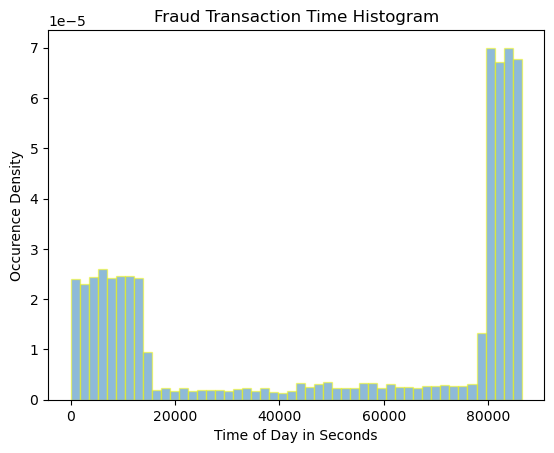

In [6]:
df['trans_time_secs'] = df['trans_date_trans_time'].apply(lambda x:\
        x.hour * 3600 + x.minute * 60 + x.second)
fraudsectimes = df.loc[df['is_fraud'] == 1, 'trans_time_secs'].reset_index(drop=True)

plt.hist(fraudsectimes, density=True, bins=50, alpha=0.5, edgecolor='yellow')
plt.title('Fraud Transaction Time Histogram')
plt.xlabel('Time of Day in Seconds')
plt.xticks(minor=True)
plt.ylabel('Occurence Density')
plt.show()

**The vast majority of fraud occurs in the hours before and after midnight.  Hence we will use transactions that fall in that window as the selected sub-feature.**

**Because these are based on the clean time series indices, this sub-feature is also clean.**

In [7]:
df['near_midnight'] = 0

df.loc[df['trans_time_secs'].between(0, 14780, inclusive='left') |\
       df['trans_time_secs'].between(78570, 86400, inclusive='right'),\
       'near_midnight'] = 1


**The sub-feature has been created.**


### Aggregate by week

**We will separate the *is_fraud* occurences in order to facilitate aggregation:**

In [8]:
df = pd.get_dummies(df, columns = ['is_fraud'])

**Now select only the columns to be used for aggregation for time series learning:**

In [9]:
df_ts = df[['trans_date_trans_time', 'is_fraud_0', 'is_fraud_1', 'near_midnight']]

**Aggregate into weekly buckets:**

In [10]:
df_ts = df_ts.resample('W', on='trans_date_trans_time').sum()
df_ts

,is_fraud_0,is_fraud_1,near_midnight
trans_date_trans_time,,,
2018-01-07,10592,49,3694
2018-01-14,10421,22,3615
2018-01-21,10439,38,3673
2018-01-28,10384,45,3601
2018-02-04,10365,37,3569
...,...,...,...
2022-12-04,24968,70,4678
2022-12-11,27493,40,5028
2022-12-18,27701,25,5001


### Analyze for an additional feature

**We will examine total transactions on holidays versus regular days:**

mean total transactions on holidays: 1626.876712328767
mean total transactions on non-holidays: 73051.55847119224


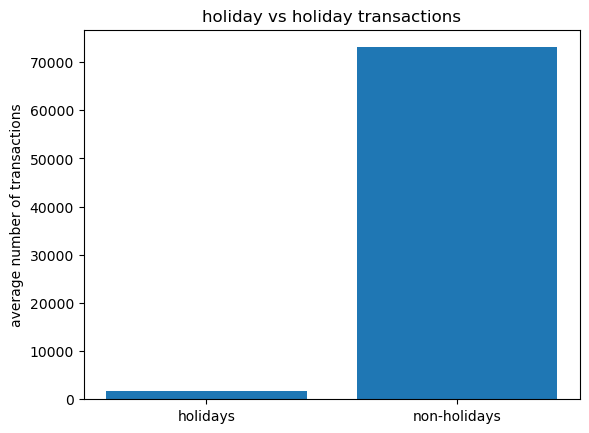

In [11]:
df['trans_date'] = pd.to_datetime(df['trans_date'])

ushols = holidays.UnitedStates(years = [2018, 2019, 2020, 2021, 2022, 2023])
transonhols = df.loc[df['trans_date'].isin(ushols.keys()), 'trans_date'].size
numhols = len(ushols.keys())

transperhol = transonhols / numhols
print('mean total transactions on holidays: {}'.format(transperhol))

transoffhols = df.size - transonhols
numregdays = df['trans_date'].unique().size - numhols

transperregday = transoffhols / numregdays
print('mean total transactions on non-holidays: {}'.format(transperregday))

plt.bar(['holidays', 'non-holidays'], [transperhol, transperregday])
plt.ylabel("average number of transactions")
plt.title("holiday vs holiday transactions")
plt.show()

**Holidays seem to be a strong predictor for a drop in total transactions.  We will add this feature now, and later see if this single-day prediction can impact weekly buckets.**

In [12]:
ushols = holidays.UnitedStates(years = [2018, 2019, 2020, 2021, 2022, 2023])
df_ts['holidays'] = 0
for period in df_ts.index:
    for hol in ushols.keys():
        delt = (period - pd.Timestamp(hol)) / np.timedelta64(1, 'D')
        # A holiday immediately before or after a week bucket could...
        # ...impact the bucket. Hence we expand the window to +-2 days...
        # ...from the week bucket.
        if -1 <= delt <= 9:
            df_ts.loc[period, 'holidays'] += 1

**rename and re-sort the columns of the aggregated dataframe:**

In [13]:
df_ts['tot_trans'] = df_ts['is_fraud_0'] + df_ts['is_fraud_1']
df_ts = df_ts.rename(columns={'is_fraud_0': 'non-fraud_trans', 'is_fraud_1': 'fraud_trans'})
# exclude the unnecessary non-fraud_trans
df_ts = df_ts[['tot_trans', 'fraud_trans', 'holidays', 'near_midnight']]
df_ts

,tot_trans,fraud_trans,holidays,near_midnight
trans_date_trans_time,,,,
2018-01-07,10641,49,1,3694
2018-01-14,10443,22,1,3615
2018-01-21,10477,38,1,3673
2018-01-28,10429,45,0,3601
2018-02-04,10402,37,0,3569
...,...,...,...,...
2022-12-04,25038,70,0,4678
2022-12-11,27533,40,0,5028
2022-12-18,27726,25,0,5001


### Feature Identification Justification

**Because this is time series analysis, any feature that is not the predicted output, or is not the specified additional feature or sub-feature, is removed.**

**In summary, we are predicting:**
* **total transactions (according to assignment)**
* **fraudulent transactions (according to assignment)**

**and we are adding:**
* **holidays as a subfeature (based on their relationship with total transactions)**
* **transactions near midnight as a feature (based on their overrepresentation of fraud cases)**


### Examine the time series

Text(0.5, 0.98, 'TRANSACTIONS PER PERIOD')

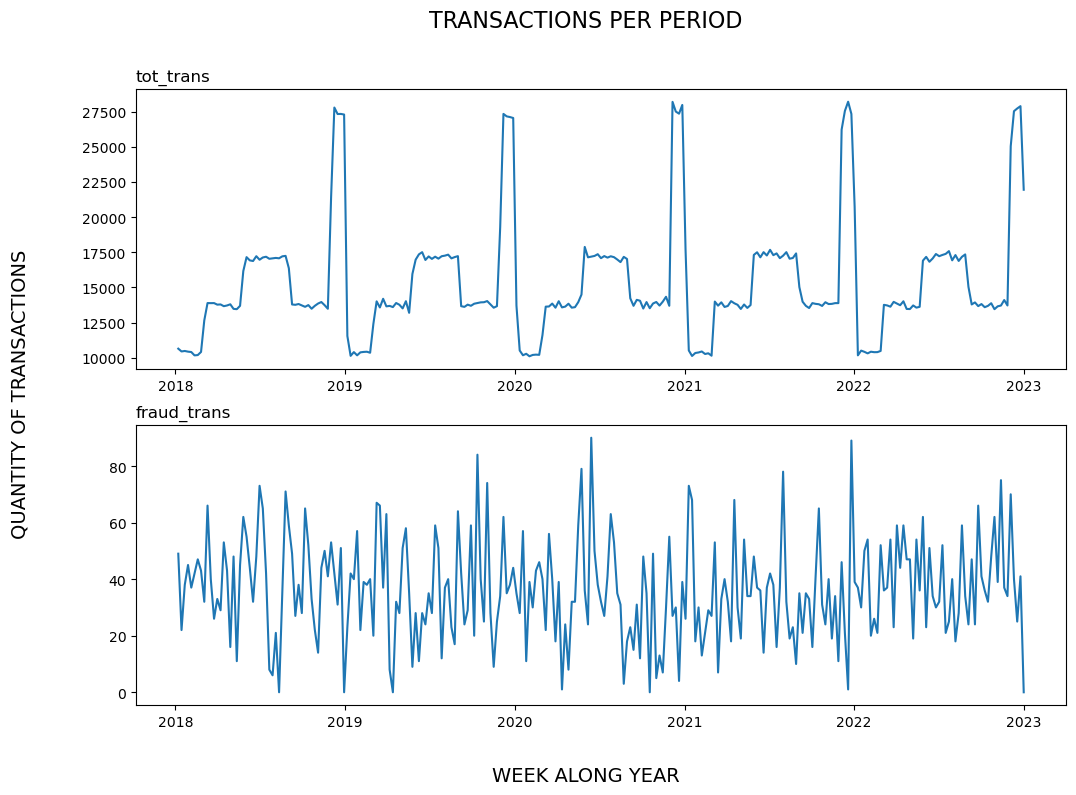

In [14]:
figlen = 2
fig, ax = plt.subplots(2, figsize=[12, 8])
for i in range(figlen):
    ax[i].plot(df_ts[df_ts.columns[i]])
    ax[i].set_title(df_ts.columns[i], loc='left')

fig.supxlabel('WEEK ALONG YEAR', fontsize=14)
fig.supylabel('QUANTITY OF TRANSACTIONS', fontsize=14)
fig.suptitle('TRANSACTIONS PER PERIOD', fontsize=16)

**As expected, there seems to be an annual seasonal effect**

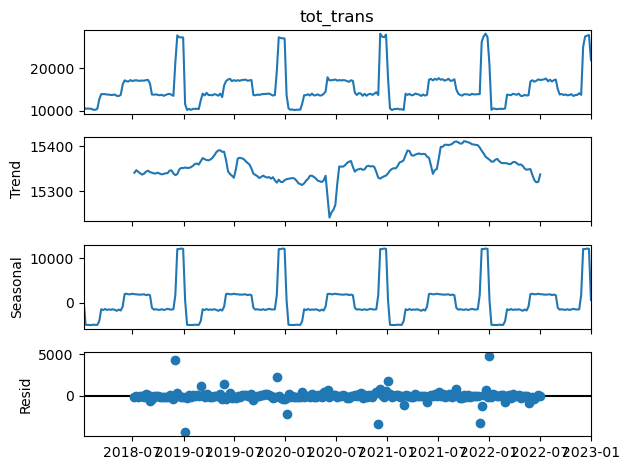

In [15]:
result = seasonal_decompose(df_ts['tot_trans'], model='add')
result.plot();

**The *Resid* plot shows outlier highs and lows seeming to occur around each holiday (Thanksgiving - New Year) period.**

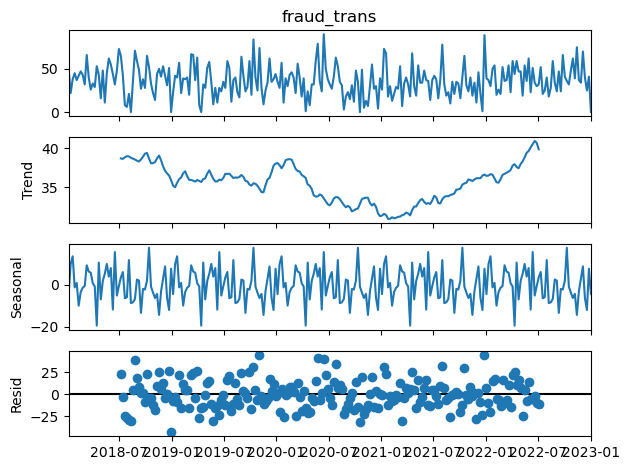

In [16]:
result = seasonal_decompose(df_ts['fraud_trans'], model='add')
result.plot();

**The *Seasonal* plot shows a disernible annual pattern.**

**Split the last year for test data**

In [17]:
X = df_ts.iloc[:-52]
Y = df_ts.iloc[-52:]

**The data is now ready for time series learning.**

## Create the Model Pipelines

**A function for METRIC comparison across models**

**We select root mean squared error (rmse) as the sole quantitative METRIC for model fit.  It measures the average distance between the predicted and truth values of a regression model.  Hence it is well suited for this problem.**

**We also plot the predictions against the truth as a qualitative indicator of model fit.**

In [18]:
def getmets(Y, feat, Y_preds, mnames, exogs):
    print('Performance for feat={}'.format(feat))
    for i, (Y_pred, mname, exog) in enumerate(zip(Y_preds, mnames, exogs)):
        error = rmse(Y[feat], Y_pred)
        print('{} exog={}, RMSE: {}'.format(mname, exog, error))
        plt.plot(Y.index, Y_pred, label='{}, exog={}'.format(mname, exog))
    plt.plot(Y.index, Y[feat], label='truth')
    plt.xlabel('weeks along years-months')
    plt.xticks(rotation=60)
    plt.ylabel('# of transactions')
    plt.title('{} Per Period'.format(feat))
    plt.legend(bbox_to_anchor=(1.5, 1.25), loc='upper right')
    plt.show()
    print()


### The *traditional* model, SARIMAX, pipeline


**First a helper for getting the SARIMAX parameters**

In [19]:
def get_sarimaxparams(verbose, feat, exog, X, method, maxiter):
    # First learn the SARIMAX parameters
    d_diffs = arima.ndiffs(X[feat], max_d=5)
    D_diffs = arima.nsdiffs(X[feat], max_D=5, m=52)
    if verbose:
        print('determining SARIMA parameters...')
    if exog == None:
        autoarimares = auto_arima(X[feat], d=d_diffs, D=D_diffs,
                         seasonal=True, m=52, trace=False,
                         stepwise=True, method=method, maxiter=maxiter)
    else:
        autoarimares = auto_arima(y=X[feat], X=X[[exog]], d=d_diffs,
                        D=D_diffs,
                        seasonal=True, m=52, trace=False,
                        stepwise=True, method=method, maxiter=maxiter)   
    order = autoarimares.get_params()['order']
    seasonal_order = autoarimares.get_params()['seasonal_order']

    pth = '../modeldat/{}-{}_{}x{}.bin'.\
            format(feat, exog, order, seasonal_order)
    with open(pth, mode='wb') as f:
        pickle.dump([order, seasonal_order], f)
            
    return order, seasonal_order

**A helper to fit the SARIMAX model**

In [20]:
def fit_SARIMAX(exog, order, seasonal_order, X, feat, verbose):
    if verbose:
        print('SARIMA parameters determined, fitting model...')
    # initiate the model
    if exog == None:  # univariate input
        mname = 'SARIMA{}x{}'.format(order, seasonal_order)
        model = SARIMAX(X[feat],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_invertibility=False)
    else:  # additional exogenous input
        mname = 'SARIMAX{}x{}'.format(order, seasonal_order)
        model = SARIMAX(X[feat],
                        exog=X[exog],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_invertibility=False)
        

    fitmod = model.fit(full_output=False,
                      disp=False)
    if verbose:
        print('SARIMAX model fitted.')
    
    return fitmod, mname

**Now the main model function**

**The ARCHITECTURE is appropriate for purely univariate or additional exogenous input, as demonstrated in lecture.**

**Based on the data analysis, we will set an annual seasonality based on 52 observations per year; refer to *get_sarimaxparams().***

In [21]:
def tradmodel(X, Y, feat, exog, method='nm', maxiter=50,
              test=True, verbose=True):
    if verbose:
        print('SARIMAX pipeline for feat={}, exog={}'.format(feat, exog))
    order, seasonal_order = get_sarimaxparams(verbose, feat, exog, X,
                                              method, maxiter)
    fitmod, mname = fit_SARIMAX(exog, order, seasonal_order, X, feat,
                                verbose)

    if test:
        start=len(X)
        end=len(X)+len(Y)-1
        # make predictions
        if exog == None:  # univariate input
            Y_pred = fitmod.predict(start=start, end=end, dynamic=False).\
                    rename('{} Predictions'.format(mname))
        else:  # additional exogenous input
            Y_pred = fitmod.predict(start=start, end=end,
                                    dynamic=False, exog=Y[[exog]]).\
                    rename('{} Predictions'.format(mname))
        if verbose:
            print('SARIMAX model tested and pipeline complete.\n')

        return Y_pred


### The *deep* model, RNN/LSTM, pipeline


**First a helper to scale the data and package/shape it for RNN learning.**

In [22]:
def rnn_preproc(X, Y, feat, exog, verbose):
    if verbose:
        print('scaling data for LSTM and creating generator...')
    colarg = [col for col in [feat, exog] if col != None]
    
    # scale the data
    scaler = MinMaxScaler()
    scaler.fit(X[colarg])
    Xsc = scaler.transform(X[colarg])
    Ysc = scaler.transform(Y[colarg])

    n_input = len(Y)
    if exog != None:
        n_features = 2
    else:
        n_features = 1
        
    # A generator provides the data shaping/packaging effect for RNN input
    generator = TimeseriesGenerator(Xsc, Xsc, length=n_input,
                                    shuffle=False, batch_size=1)

    return Xsc, Ysc, scaler, generator, n_input, n_features


**A helper to define and train the model.**

In [23]:
def trainLSTM(units, n_input, n_features, feat, exog, verbose, generator):
    # define the model
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # control model saving and stopping criteria
    cp_cb = ModelCheckpoint(
            filepath='../modeldat/{}-{}_{}.tfmod'.format(feat, exog, units),
            save_weights_only = False,
            monitor = 'loss',
            mode = 'min',
            save_best_only = True)
    es_cb = EarlyStopping(restore_best_weights=True, 
            monitor='loss', mode='min',
            patience=5, start_from_epoch=30)
    
    if verbose:
        print('training LSTM model...')
    model.fit(generator, epochs=200, verbose=0, callbacks=[cp_cb, es_cb])
    if verbose:
        print('LSTM model trained.')
    
    return model

**Now the main model function**

**The ARCHITECTURE is appropriate for single or double feature input.**

**Note the modification to the testing code.  Here we append the truth second input (we can append anything, but choose the truth num of holidays to isolate how the model predicts the desired output, rather than subjecting the desired output prediction to an also-predicted num of holidays).**

**As with the traditional model, the generator will account for the seasonality by using the test data length; refer to *rnn_preproc().***

In [24]:
def deepmodel(X, Y, feat, exog, units=96, test=True, verbose=True):
    if verbose:
        print('LSTM pipeline for feat={}, exog={}...'.format(feat, exog))
    # scale and package/shape the data for RNN learning
    Xsc, Ysc, scaler, generator, n_input, n_features =\
            rnn_preproc(X, Y, feat, exog, verbose)
    model = trainLSTM(units, n_input, n_features, feat, exog, verbose,
                      generator)
 
    if test:
        Y_pred = []
        # the last sequence of inputs leading to edge of prediction
        first_eval_batch = Xsc[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
        # predict 1 bucket at a time into the test data range
        for i in range(len(Ysc)):
            # get next bucket prediction
            current_pred = model.predict(current_batch, verbose=0)[0]
            # store prediction
            if exog == None:
                Y_pred.append(current_pred)
            else:
                # must add the truth num of holidays to the prediction
                current_pred = np.append(current_pred, Ysc[i, 1])
                Y_pred.append(current_pred)
            # update batch to now include prediction and drop first value
            current_batch = np.append(current_batch[:, 1:, :],
                                      np.array([[current_pred]]), axis=1)

        # Reshaping/slice due to the dynamics of Numpy, Tensorflow, and Sklearn
        if exog == None:
            Y_pred = np.squeeze(scaler.inverse_transform(Y_pred), axis=1)
        else:
            Y_pred = scaler.inverse_transform(Y_pred)[:, 0]
        if verbose:
            print('LSTM model fitted/tested and pipeline complete.\n')

        return Y_pred


## Hyperparameter Tuning

**We will tune the traditional model on its *auto_arima* solver**

In [25]:
def tune_tradmodel(X, Y):
    feat = 'tot_trans'
    methods = ['nm', 'lbfgs']
    for method in methods:
            starttime = time.time()
            Y_pred = tradmodel(X, Y, feat, exog=None, method=method,
                               maxiter=30, verbose=False)
            runtime = time.time() - starttime
            error = rmse(Y[feat], Y_pred)
            print('method={}, runtime={:.3f}, error={:.6f}\n'.\
                  format(method, runtime, error))

tune_tradmodel(X, Y)

method=nm, runtime=22.913, error=5822.928406

method=lbfgs, runtime=170.166, error=394.837193



***lbfgs* and *maxiter=30* shows a dramatically improved performance.  For runtime purposes, however, we select *nm* and *maxiter=30*.**

**We will tune the deep model on *units***

In [26]:
def tune_deepmodel(X, Y):
    feat = 'fraud_trans'
    unitsall = [64, 128]
    for units in unitsall:
        starttime = time.time()
        Y_pred = deepmodel(X, Y, feat, exog=None,
                           units=units,
                           verbose=False)
        runtime = time.time() - starttime
        error = rmse(Y[feat], Y_pred)
        print('units={}, runtime={:.3f}, error={:.3f}'.\
              format(units, runtime, error))

tune_deepmodel(X, Y)

2024-04-08 03:10:25.144256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 03:10:25.181723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 03:10:25.181994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

units=64, runtime=166.437, error=15.602
units=128, runtime=169.808, error=15.323


***units*=64 shows comparable loss performance.  Runtime wise, the network/batch fits on the GPU, regardless of the tuned neuron quantity (64 or 128); hence runtime will be more sensitive to weight initialization than neuron quantitiy.  Since *units=64* also allows at least as many LSTM neurons as there are seasonal input points, we will select *units=64* for network simplicity purposes.**

## Model Evaluation

In [27]:
def trad_vs_deep(X, Y):
    feats = ['tot_trans', 'fraud_trans']
    exogs = [None, 'holidays', 'near_midnight']

    for feat in feats:
        Y_preds = []
        usedmnames = []
        usedexogs = []
        for exog in exogs:
            if feat == 'fraud_trans' and exog == 'holidays':
                pass
            else:
                Y_pred_trad = tradmodel(X, Y, feat, exog,\
                        method='nm', maxiter=30, verbose=False)
                Y_preds.append(Y_pred_trad)
                usedmnames.append('SARIMAX')
                usedexogs.append(exog)
                Y_pred_deep = deepmodel(X, Y, feat, exog,\
                        units=64, verbose=False)
                Y_preds.append(Y_pred_deep)
                usedmnames.append('LSTM')
                usedexogs.append(exog)

        getmets(Y, feat, Y_preds, usedmnames, usedexogs)


Performance for feat=tot_trans
SARIMAX exog=None, RMSE: 5822.928405853056
LSTM exog=None, RMSE: 2254.5532350384738
SARIMAX exog=holidays, RMSE: 7447.351756477914
LSTM exog=holidays, RMSE: 3991.8844940408767
SARIMAX exog=near_midnight, RMSE: 2126.1383284833946
LSTM exog=near_midnight, RMSE: 3252.3630283477505


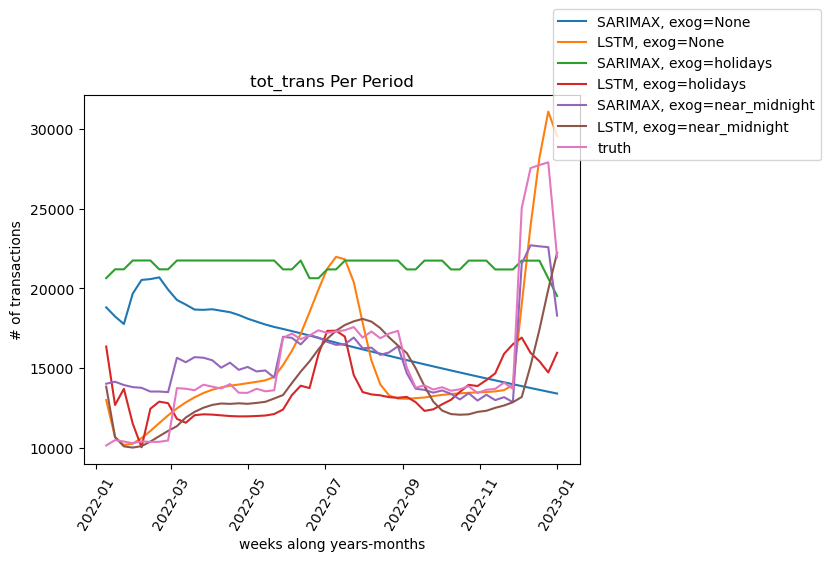


Performance for feat=fraud_trans
SARIMAX exog=None, RMSE: 42.38491204698636
LSTM exog=None, RMSE: 17.692539516571024
SARIMAX exog=near_midnight, RMSE: 23.327716998753253
LSTM exog=near_midnight, RMSE: 23.14133507942424


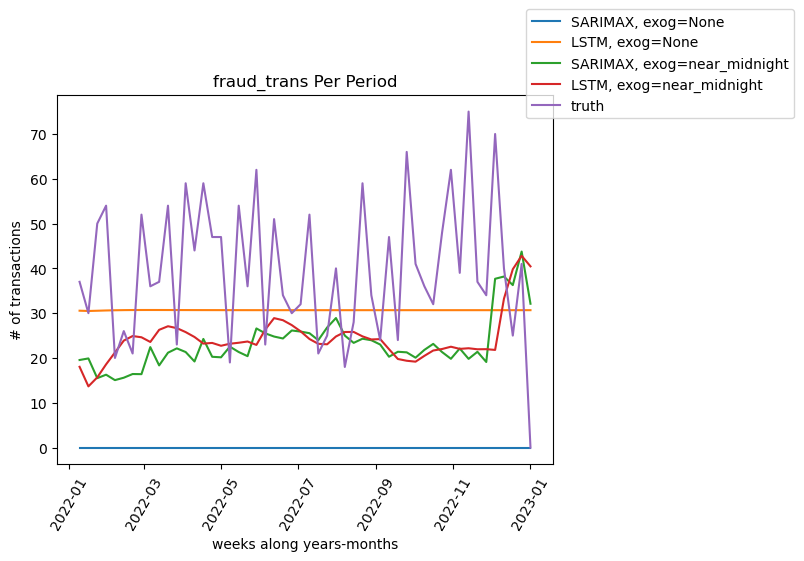

In [28]:
trad_vs_deep(X, Y)

**1. A traditional and deep model that forecasts the number of total transactions including fraudulent ones.  Compare results for each model.**  
SARIMA and LSTM were selected.  They are blue/orange in the upper plot, and the first 2 rows in the output above the upper plot.  The LSTM has a better qualitative fit (plot) and quantitative fit (RMSE).

**2. A traditional and deep model that forecasts the number of fraudulent transactions. Compare results for each model.**  

SARIMA and LSTM were selected.  They are blue/orange in the lower plot.  They are blue/orange in the lower plot, and the first 2 rows in the output above the lower plot.  The LSTM has a better qualitative fit (plot) and quantitative fit (RMSE).

**3. A traditional and deep model that forecast the number of total transactions with the addition of an extra feature - justify the feature.  Compare to the model results in 1.**  

SARIMAX and LSTM, both using holidays were selected.  They are green/red in the upper plot, and the middle 2 rows in the output above the upper plot.  The LSTM has a better qualitative and quantitative fit.  

Holidays were selected based on the justification in **Analyze for an additional feature** earlier in the notebook.

**4. A traditional and deep model the forecasts the number of transactions and fraudulent transactions given a selected (you select with justification) sub-feature such as a specific product category, location, amount range, and such.  Summarize your findings.**  

SARIMAX and LSTM, both using number of transactions proximal to midnight, were selected.  They are purple/brown in the upper plot and green/red in the lower plot.  Their RMSEs are the 2nd/3rd rows in the output above the upper plot, and the 3rd/4th rows in the output above the lower plot.

SARIMAX has a better qualitative and quantitative fit for total transactions.  For fraudulent transactions, SARIMAX has a slightly better quantitative fit and a comparable qualitative fit versus LSTM.  

This subfeature was selected based on the justification in **Analyze for a sub-feature** earlier in the notebook.

**SUMMARY**

**The LSTM performed better, both qualitatively and quantitatively, when there was no exogenous feature intoduced.**

**With exogenous features, SARIMAX performed better on when transactions proximal to midnight were added.**

**To ensure ensure the webservice is not reliant on an additional variable (which would have to be guessed), we will select the LSTM for both total and fraudulent transaction predictions.**

## Retrain Selected Models on All Data

**Create a training dataframe of all the data.**

In [29]:
Xall = df_ts.iloc[:]


**Train the selected models again for the specified features, outputs, and hyperparameters.  Do not run through testing.**

In [31]:
def train_on_all(Xall, Y):
    _ = deepmodel(Xall, Y, 'tot_trans', None, units=64, test=False)
    
    _ = deepmodel(Xall, Y, 'fraud_trans', None, units=64, test=False)
    
train_on_all(Xall, Y)

LSTM pipeline for feat=tot_trans, exog=None...
scaling data for LSTM and creating generator...
training LSTM model...
LSTM model trained.
LSTM pipeline for feat=fraud_trans, exog=None...
scaling data for LSTM and creating generator...
training LSTM model...
LSTM model trained.


**The Tensorflow models for each case (total transaction prediction and fraudulent transaction prediction) are now saved.  These will be loaded for the web service backend code to avoid re-fitting.**